# Capstone Three: 3. Modeling - Supervised<a id='3'></a>

## 3.1 Contents<a id='3.1'></a>
* [3. Modeling - Supervised](#3)
  * [3.1 Contents](#3.1)
  * [3.2 Imports](#3.2)
  * [3.3 Load Data](#3.3)
  * [3.4 Preprocessing and Modeling (W/O Resampling)](#3.4)
    * [3.4.1 Train-test Split and Standard Scaling](#3.4.1) 
    * [3.4.2 Logistic Regression](#3.4.2)
    * [3.4.3 XGBoost](#3.4.3)
    * [3.4.4 LightGBM](#3.4.4)
  * [3.5 Preproceesing and Modeling (W/ Resampling)](#3.5)
    * [3.5.1 Resampling (SMOTE-ENN), Train-Test Split, and Scaling](#3.5.1)
    * [3.5.2 Logistic Regression](#3.5.2)
    * [3.5.3 XGBoost](#3.5.3)
    * [3.5.4 LightGBM](#3.5.4)
  * [3.6 Summary](#3.6)

## 3.2 Imports<a id='3.2'></a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

## 3.3 Load Data<a id='3.3'></a>

In [2]:
data = pd.read_csv("creditcard.csv")
data.drop_duplicates(inplace=True)
data = data.drop(columns=['Time'])

X = data.values[:,:-1]       # Predictors
y = data.values[:,-1]        # Predictand

## 3.4 Preprocessing and Modeling (W/O Resampling)<a id='3.4'></a>

### 3.4.1 Train-test Split and Standard Scaling<a id='3.4.1'></a>

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, 
                                                    random_state = 42, stratify=y)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### 3.4.2 Logistic Regression<a id='3.4.2'></a>

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56651
         1.0       0.85      0.58      0.69        95

    accuracy                           1.00     56746
   macro avg       0.92      0.79      0.84     56746
weighted avg       1.00      1.00      1.00     56746

F1 score:0.6875


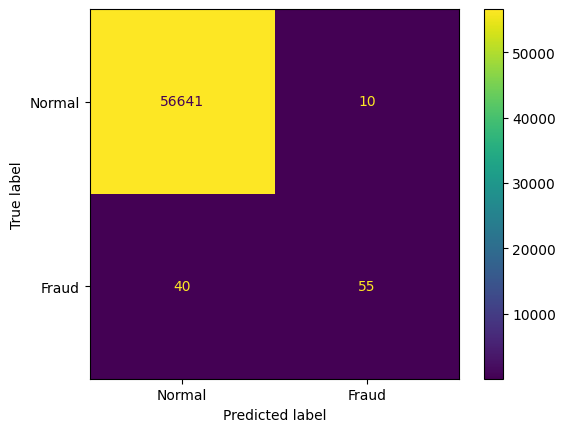

In [4]:
logisticRegr = LogisticRegression(solver = 'liblinear', max_iter = 500, C = 1000)
logisticRegr.fit(X_train, y_train)
y_pred = logisticRegr.predict(X_test)
print(classification_report(y_test, y_pred))
print("F1 score:{0:.4f}".format(f1_score(y_test, y_pred, average='binary')))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['Normal', 'Fraud'])
disp.plot()
plt.show()

### 3.4.3 XGBoost<a id='3.4.3'></a>

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56651
         1.0       0.97      0.76      0.85        95

    accuracy                           1.00     56746
   macro avg       0.99      0.88      0.93     56746
weighted avg       1.00      1.00      1.00     56746

F1 score:0.8521


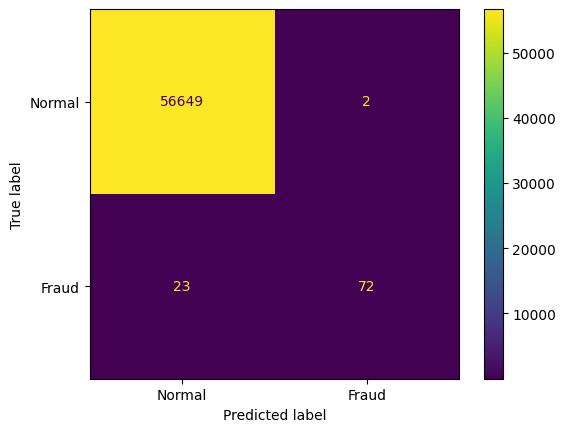

In [5]:
xbg = XGBClassifier(learning_rate=0.2, max_depth=5, n_estimators=500)
xbg.fit(X_train, y_train)
y_pred = xbg.predict(X_test)
print(classification_report(y_test, y_pred))
print("F1 score:{0:.4f}".format(f1_score(y_test, y_pred, average='binary')))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['Normal', 'Fraud'])
disp.plot()
plt.show()

### 3.4.4 LightGBM<a id='3.4.4'></a>

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56651
         1.0       0.61      0.48      0.54        95

    accuracy                           1.00     56746
   macro avg       0.81      0.74      0.77     56746
weighted avg       1.00      1.00      1.00     56746

F1 score:0.5412


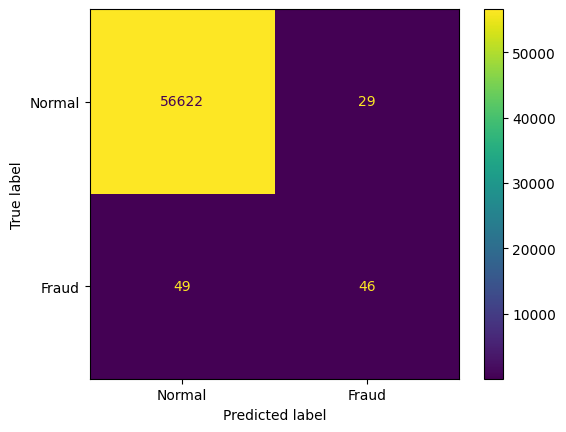

In [6]:
lgb = LGBMClassifier(learning_rate=0.2, max_depth=-1, n_estimators=500, num_leaves=5, verbose=-1)
lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_test)
print(classification_report(y_test, y_pred))
print("F1 score:{0:.4f}".format(f1_score(y_test, y_pred, average='binary')))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['Normal', 'Fraud'])
disp.plot()
plt.show()

XGboost gives the highest F1 score of 0.85. Logistic regression has an F1 score of 0.69. LightGBM is worst (F1 score=0.54), having True Positive (46) even less than False Positive (49).

## 3.5 Preproceesing and Modeling (W/ Resampling)<a id='3.5'></a>

### 3.5.1 Resampling (SMOTE-ENN), Train-Test Split, and Scaling<a id='3.5.1'></a>

In [7]:
# Ramdomly select 10000 normal observations to reduce size.
class_Fraud = data.Class.values
index_nF = np.array(data.index[data.Class == 0])
index_F = np.array(data.index[data.Class == 1])
np.random.shuffle(index_nF)
index = np.concatenate((index_nF[0:10000],index_F))
index.sort()
X_reduce = data.loc[index].values[:,:-1]
y_reduce = data.loc[index].values[:,-1]
X = X_reduce
y = y_reduce

# Resampling
rsp = SMOTEENN()
X_rsp, y_rsp = rsp.fit_resample(X, y)

# Train and test data splitting
X_train, X_test, y_train, y_test = train_test_split(X_rsp, y_rsp, train_size = 0.8, random_state = 42, stratify=y_rsp)

# Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### 3.5.2 Logistic Regression<a id='3.5.2'></a>

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96      1913
         1.0       0.98      0.95      0.96      1985

    accuracy                           0.96      3898
   macro avg       0.96      0.96      0.96      3898
weighted avg       0.96      0.96      0.96      3898

F1 score:0.9624


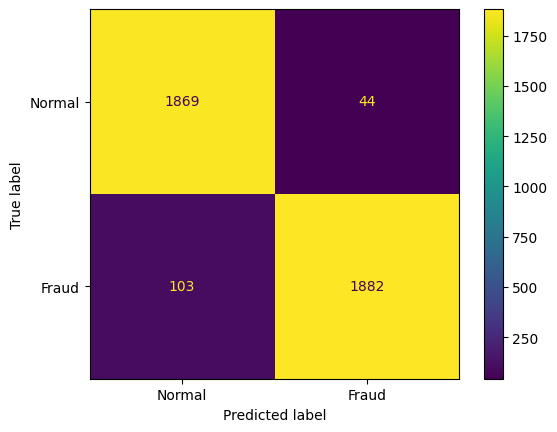

In [8]:
logisticRegr = LogisticRegression(solver = 'liblinear', max_iter = 500, C = 1000)
logisticRegr.fit(X_train, y_train)
y_pred = logisticRegr.predict(X_test)
print(classification_report(y_test, y_pred))
print("F1 score:{0:.4f}".format(f1_score(y_test, y_pred, average='binary')))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['Normal', 'Fraud'])
disp.plot()
plt.show()

### 3.5.3 XGBoost<a id='3.5.3'></a>

best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 500}

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1913
         1.0       1.00      1.00      1.00      1985

    accuracy                           1.00      3898
   macro avg       1.00      1.00      1.00      3898
weighted avg       1.00      1.00      1.00      3898

F1 score:0.9980


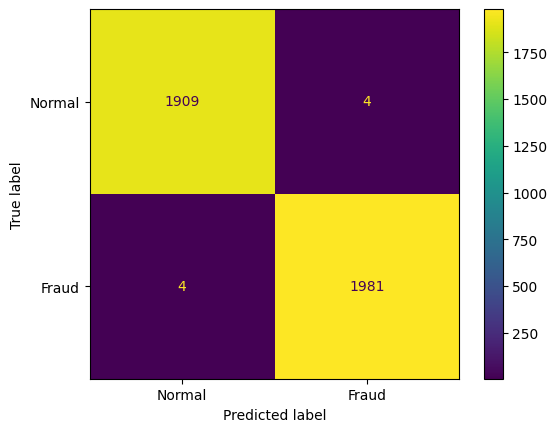

In [9]:
# Idenfity optimal parameters using GridSearchCV
xbg = XGBClassifier()
max_depth = [3, 5, 10, 15]
learning_rate = [0.001, 0.01, 0.1, 0.2]
n_estimators = [100, 200, 300, 500]
params = {
    'max_depth': max_depth,
    'learning_rate': learning_rate,
    'n_estimators': n_estimators,
}

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(xbg, params, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("best parameters:", best_params)
print("")

# Prediction using best parameters
xbg_best = XGBClassifier(**best_params)
xbg_best.fit(X_train, y_train)
y_pred = xbg_best.predict(X_test)
print(classification_report(y_test, y_pred))
print("F1 score:{0:.4f}".format(f1_score(y_test, y_pred, average='binary')))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['Normal', 'Fraud'])
disp.plot()
plt.show()

### 3.5.4 LightGBM<a id='3.5.4'></a>

best parameters: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 500, 'num_leaves': 11}

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1913
         1.0       1.00      1.00      1.00      1985

    accuracy                           1.00      3898
   macro avg       1.00      1.00      1.00      3898
weighted avg       1.00      1.00      1.00      3898

F1 score:0.9980


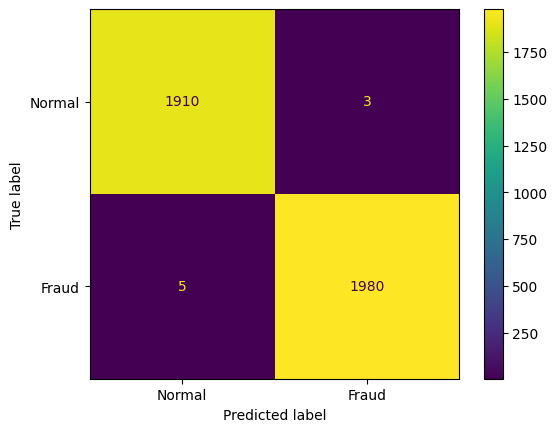

In [10]:
# Idenfity optimal parameters using GridSearchCV
lgb = LGBMClassifier(verbose=-1)
max_depth = [-1, -3, -5]
learning_rate = [0.001, 0.01, 0.1, 0.2]
n_estimators = [500]
num_leaves = [5, 11, 21, 31]
params = {
    'max_depth': max_depth,
    'learning_rate': learning_rate,
    'n_estimators': n_estimators,
    'num_leaves': num_leaves
}

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(lgb, params, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("best parameters:", best_params)
print("")

# Prediction using best parameters
lgb_best = LGBMClassifier(**best_params,verbose=-1)
lgb_best.fit(X_train, y_train)
y_pred = lgb_best.predict(X_test)
print(classification_report(y_test, y_pred))
print("F1 score:{0:.4f}".format(f1_score(y_test, y_pred, average='binary')))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['Normal', 'Fraud'])
disp.plot()
plt.show()

## 3.6 Summary<a id='3.6'></a>

**Without Resampling:**

**XGBoost** gives the highest F1 score of 0.85. \
Logistic Regression has an F1 score of 0.69. \
LightGBM shows the lowest F1 score of 0.54, having True Positive (46) even less than False Positive (49).

**After Applying Resampling:**

All three algorithms preformed very well. \
Logistic Regression shows a relatively lower F1 score of 0.96. \
Both XGBoost and LightGBM give a very high F1 score of 0.998. \
In comparison, **LightGBM** is more efficient, with half the running time of XGBoost.